In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, linregress, kruskal
from scikit_posthocs import posthoc_dunn

In [2]:
#load de novo data
df = pd.read_csv("Data/per_residue_disorder_MSA_pLDDT_deNovo.csv", index_col=0)
df["MSA_log"] = np.log10(df["MSA_Depth"])

denovo_data = pd.read_csv("Data/de_novo_proteins_data.csv", index_col=0)
denovo_data = denovo_data[(denovo_data["mechanism"] == "denovo") | (denovo_data["mechanism"] == "denovo-intron")]

#load random data
rd = pd.read_csv("Data/per_residue_disorder_MSA_pLDDT_randomSequences.csv", index_col=0)
rd["MSA_log"] = np.log10(rd["MSA_Depth"])

random_data = pd.read_csv("Data/random_sequences_data.csv", index_col=0)
random_data["seqLen"] = random_data["sequence"].apply(len)

#load established data
con = pd.read_csv("Data/per_residue_disorder_MSA_pLDDT_conservedProteins.csv", index_col=0)
con["MSA_log"] = np.log10(con["MSA_Depth"])
con = con[con["isDeNovo"] == False]

established_data = pd.read_csv("Data/established_proteins_data.csv", index_col=0)
established_data = established_data[established_data["isDeNovo"] == False]

#assign length quartiles & age groups

first_quartile = np.percentile(denovo_data["seqLen"], 25)
second_quartile = np.percentile(denovo_data["seqLen"], 50)
third_quartile = np.percentile(denovo_data["seqLen"], 75)
fourth_quartile = np.percentile(denovo_data["seqLen"], 100)

def assign_length_quartile(length):
    if length <= first_quartile:
        return 1
    elif length <= second_quartile:
        return 2
    elif length <= third_quartile:
        return 3
    else:
        return 4

def assign_Age_group(x):
    if x < 5:
        return 1
    elif x < 30:
        return 2
    else:
        return 3



denovo_dict = {}
denovo_seqlen = {}
for protein in df["id"].unique():
    seqLen = denovo_data[denovo_data["id"] == protein]["seqLen"].values[0]
    denovo_seqlen[protein] = seqLen
    denovo_dict[protein] = assign_length_quartile(seqLen)

random_dict = {}
random_seqlen = {}
for protein in rd["id"].unique():
    seqLen = random_data[random_data["id"] == protein]["seqLen"].values[0]
    random_seqlen[protein] = seqLen
    random_dict[protein] = assign_length_quartile(seqLen)

established_dict = {}
established_seqlen = {}
for protein in con["id"].unique():
    try:
        seqLen = established_data[established_data["id"] == protein]["seqLen"].values[0]
        established_seqlen[protein] = seqLen
        established_dict[protein] = assign_length_quartile(seqLen)
    except:
        pass


age_dict = {}
for protein in df["id"].unique():
    age = denovo_data[denovo_data["id"] == protein]["age"].values[0]
    age_dict[protein] = assign_Age_group(age)

df["length_quartile"] = df["id"].map(denovo_dict)
df["age_group"] = df["id"].map(age_dict)
rd["length_quartile"] = rd["id"].map(random_dict)
con["length_quartile"] = con["id"].map(established_dict)



In [3]:
# Add Amino acid per position

def assign_amino_acids(df, ref):
    # Assigns amino acids to the dataframe based on a reference sequence
    # The reference sequence is provided in the 'ref' dataframe

    df["AA"] = np.nan  # Creates a new column for amino acids in the dataframe

    for id in df["id"].unique():
        try:
            seq = ref[ref["id"] == id]["sequence"].iloc[0]  # Retrieves the sequence for the given ID from the reference dataframe
            seq = [x for x in seq]  # Converts the sequence string to a list of individual amino acids
            df.loc[df["id"] == id, "AA"] = seq  # Assigns the amino acid list to the corresponding rows in the dataframe
        except:
            print(f"failed at {id}")  

    return df  # Returns the modified dataframe with amino acids assigned

df = assign_amino_acids(df, denovo_data)
rd = assign_amino_acids(rd, random_data)
con = assign_amino_acids(con, established_data)



failed at rand_2507


---
## Plot Data

AttributeError: 'FacetGrid' object has no attribute 'tick_params'

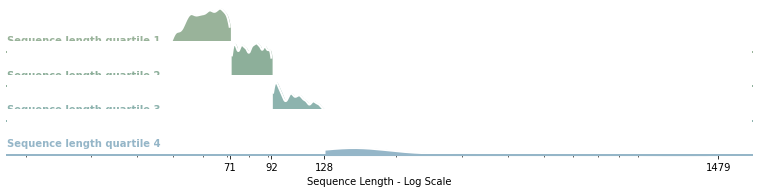

In [4]:
palette = ["#99B39A", "#8DAF9A", "#8DB3AE", "#95B6C8"]

x = np.array(denovo_data["seqLen"])
r = np.array(denovo_data["seqLen"].apply(lambda x: assign_length_quartile(x)))
d = pd.DataFrame(dict(x=x, r=r))
#d = d[d["r"] < 4]


g = sns.FacetGrid(d, row="r", hue="r", aspect=15, height=0.75, palette=palette)


g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5, cut=0)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5, cut=0)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    
    ax.text(0, .25, "Sequence length quartile " + label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlabel="Sequence Length - Log Scale")
g.set(xscale="log")
g.set(xticks=[])
g.set(xticks=[first_quartile, second_quartile, third_quartile, fourth_quartile])
g.set(xticklabels=[int(x) for x in [first_quartile, second_quartile, third_quartile, fourth_quartile]])
g.tick_params(axis="x", which="both", size=0, pad=7.5)
g.refline(x=first_quartile, linewidth=1, linestyle="--",)
g.refline(x=second_quartile, linewidth=1, linestyle="--",)
g.refline(x=third_quartile, linewidth=1, linestyle="--",)
g.refline(x=fourth_quartile, linewidth=1, linestyle="--",)
plt.tight_layout()

#plt.savefig("sequence_length_quartiles_distribution.png", dpi=600)


In [5]:
def calc_stats(df, group):
    #calculate significance using kruskal-wallis test and dunn's post-hoc test
    kw_msa = kruskal(df[df["length_quartile"] == 1]["MSA_log"], df[df["length_quartile"] == 2]["MSA_log"], df[df["length_quartile"] == 3]["MSA_log"], df[df["length_quartile"] == 4]["MSA_log"])
    data_msa = [df[df["length_quartile"] == 1]["MSA_log"], df[df["length_quartile"] == 2]["MSA_log"], df[df["length_quartile"] == 3]["MSA_log"], df[df["length_quartile"] == 4]["MSA_log"]]
    dunn_msa = posthoc_dunn(data_msa, p_adjust = 'holm')
    
    print(f"-------------------{group}-------------------")
    
    print(f"Kruskal-Wallis test for MSA Depth: {kw_msa}")
    print(f"Dunn's post-hoc test for MSA Depth:\n{dunn_msa}")

    print("\n")

    kw_plddt = kruskal(df[df["length_quartile"] == 1]["pLDDT"], df[df["length_quartile"] == 2]["pLDDT"], df[df["length_quartile"] == 3]["pLDDT"], df[df["length_quartile"] == 4]["pLDDT"])
    data_plddt = [df[df["length_quartile"] == 1]["pLDDT"], df[df["length_quartile"] == 2]["pLDDT"], df[df["length_quartile"] == 3]["pLDDT"], df[df["length_quartile"] == 4]["pLDDT"]]
    dunn_plddt = posthoc_dunn(data_plddt, p_adjust = 'holm')
    print(f"Kruskal-Wallis test for pLDDT: {kw_plddt}")
    print(f"Dunn's post-hoc test for pLDDT:\n{dunn_plddt}")

    print("\n")
    kw_disorder = kruskal(df[df["length_quartile"] == 1]["Disorder_flDPnn"], df[df["length_quartile"] == 2]["Disorder_flDPnn"], df[df["length_quartile"] == 3]["Disorder_flDPnn"], df[df["length_quartile"] == 4]["Disorder_flDPnn"])
    data_disorder = [df[df["length_quartile"] == 1]["Disorder_flDPnn"], df[df["length_quartile"] == 2]["Disorder_flDPnn"], df[df["length_quartile"] == 3]["Disorder_flDPnn"], df[df["length_quartile"] == 4]["Disorder_flDPnn"]]
    dunn_disorder = posthoc_dunn(data_disorder, p_adjust = 'holm')
    print(f"Kruskal-Wallis test for disorder: {kw_disorder}")
    print(f"Dunn's post-hoc test for disorder:\n{dunn_disorder}")

-------------------Random Sequences-------------------
Kruskal-Wallis test for MSA Depth: KruskalResult(statistic=17587.721896461233, pvalue=0.0)
Dunn's post-hoc test for MSA Depth:
              1             2             3    4
1  1.000000e+00  2.782990e-03  1.943224e-30  0.0
2  2.782990e-03  1.000000e+00  3.169527e-57  0.0
3  1.943224e-30  3.169527e-57  1.000000e+00  0.0
4  0.000000e+00  0.000000e+00  0.000000e+00  1.0


Kruskal-Wallis test for pLDDT: KruskalResult(statistic=109625.73406960268, pvalue=0.0)
Dunn's post-hoc test for pLDDT:
     1    2    3    4
1  1.0  0.0  0.0  0.0
2  0.0  1.0  0.0  0.0
3  0.0  0.0  1.0  0.0
4  0.0  0.0  0.0  1.0


Kruskal-Wallis test for disorder: KruskalResult(statistic=17750.518938947465, pvalue=0.0)
Dunn's post-hoc test for disorder:
     1    2             3             4
1  1.0  0.0  0.000000e+00  0.000000e+00
2  0.0  1.0  0.000000e+00  0.000000e+00
3  0.0  0.0  1.000000e+00  1.665051e-77
4  0.0  0.0  1.665051e-77  1.000000e+00
---------------

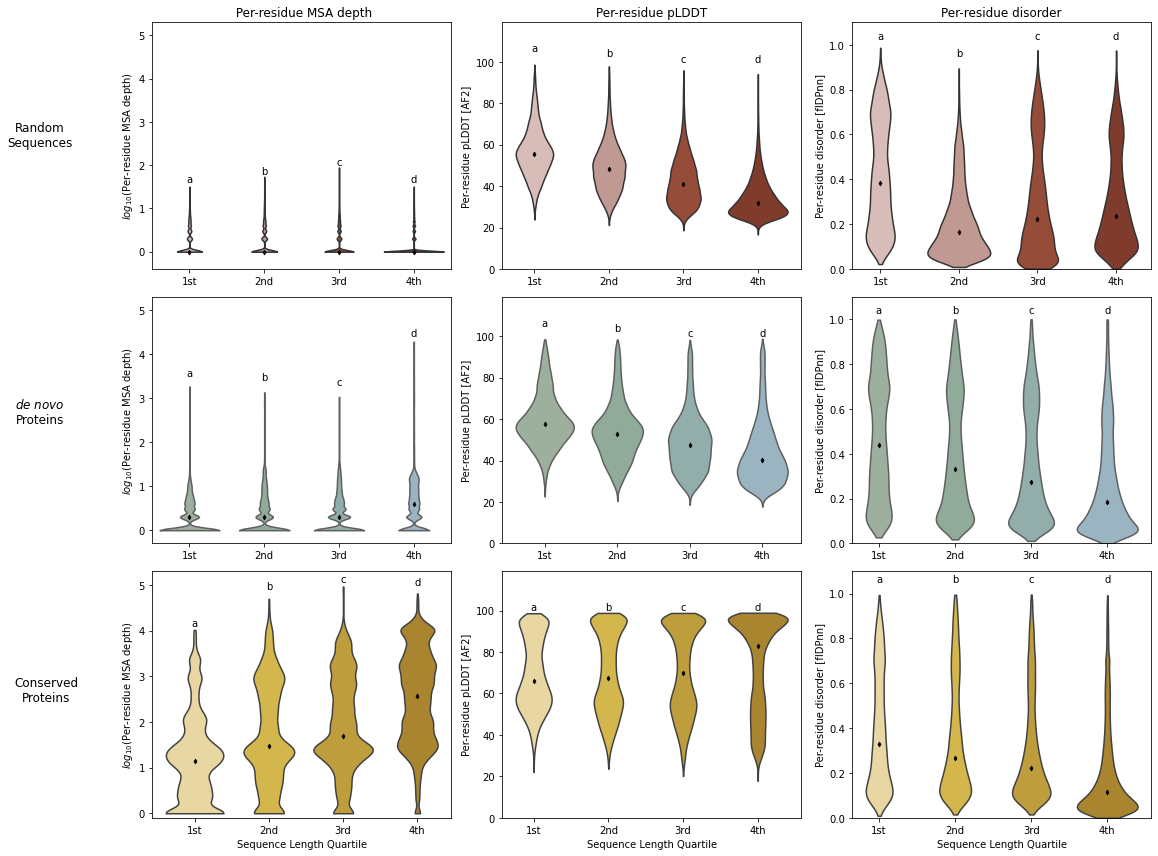

In [6]:
#create 3x3 plot with all per-residue plots

fig, ax = plt.subplots(3, 3, figsize=(16, 12))

####################
# Random Plot
####################

calc_stats(rd, "Random Sequences")

palette_rd = ["#DDB8B3", "#C7938B", "#A44328", "#8D331F"]

sns.violinplot(x="length_quartile", y="MSA_log", data=rd, ax=ax[0, 0], inner=None, cut=0, palette=palette_rd)
ax[0, 0].scatter([0, 1, 2, 3], rd.groupby("length_quartile")["MSA_log"].median(), color="black", s=10, marker="d")
ax[0, 0].set_ylabel(r"$log_{10}$(Per-residue MSA depth)")
ax[0,0].set_xlabel("")
ax[0, 0].set_ylim(-0.4, 5.3)
ax[0, 0].set_yticks([0,1,2,3,4, 5])
ax[0,0].set_xlim(-0.5, 3.5)

sns.violinplot(x="length_quartile", y="pLDDT", data=rd, ax=ax[0, 1], inner=None, cut=0, palette=palette_rd)
ax[0,1].scatter([0, 1, 2, 3], rd.groupby("length_quartile")["pLDDT"].median(), color="black", s=10, marker="d")
ax[0,1].set_ylabel("Per-residue pLDDT [AF2]")
ax[0,1].set_ylim(0, 119)
ax[0,1].set_xlabel("")



sns.violinplot(x="length_quartile", y="Disorder_flDPnn", data=rd, ax=ax[0, 2], inner=None, cut=0, palette=palette_rd)
ax[0,2].scatter([0, 1, 2, 3], rd.groupby("length_quartile")["Disorder_flDPnn"].median(), color="black", s=10, marker="d")
ax[0,2].set_ylabel("Per-residue disorder [flDPnn]")
ax[0,2].set_xlabel("")
ax[0,2].set_ylim(0, 1.1)


ax[0,0].set_xticklabels(["1st", "2nd", "3rd", "4th"])
ax[0,1].set_xticklabels(["1st", "2nd", "3rd", "4th"])
ax[0,2].set_xticklabels(["1st", "2nd", "3rd", "4th"])

#set titles

ax[0, 0].set_title(" Per-residue MSA depth")
ax[0, 1].set_title("Per-residue pLDDT")
ax[0 ,2].set_title("Per-residue disorder")

#add stats
ax[0,0].text(0, 1.6, "a", ha="center")
ax[0,0].text(1, 1.8, "b", ha="center")
ax[0,0].text(2, 2.0, "c", ha="center")
ax[0,0].text(3, 1.6, "d", ha="center")

ax[0,1].text(0, 105, "a", ha="center")
ax[0,1].text(1, 102.5, "b", ha="center")
ax[0,1].text(2, 100, "c", ha="center")
ax[0,1].text(3, 100, "d", ha="center")

ax[0,2].text(0, 1.025, "a", ha="center")
ax[0,2].text(1, 0.95, "b", ha="center")
ax[0,2].text(2, 1.025, "c", ha="center")
ax[0,2].text(3, 1.025, "d", ha="center")

####################
# de novo Plot
####################

calc_stats(df, "de novo Proteins")

sns.violinplot(x="length_quartile", y="MSA_log", data=df, ax=ax[1,0], inner=None, cut=0, palette=palette)
ax[1,0].scatter([0, 1, 2, 3], df.groupby("length_quartile")["MSA_log"].median(), color="black", s=10, marker="d")
ax[1,0].set_ylabel(r"$log_{10}$(Per-residue MSA depth)")
ax[1,0].set_xlabel("")
ax[1,0].set_xlim(-0.5, 3.5)
ax[1,0].set_ylim(-0.3, 5.3)



sns.violinplot(x="length_quartile", y="pLDDT", data=df, ax=ax[1,1], inner=None, cut=0, palette=palette)
ax[1,1].scatter([0, 1, 2, 3], df.groupby("length_quartile")["pLDDT"].median(), color="black", s=10, marker="d")
ax[1,1].set_ylabel("Per-residue pLDDT [AF2]")
ax[1,1].set_ylim(0, 119)
ax[1,1].set_xlabel("")




ax[1,0].set_xticklabels(["1st", "2nd", "3rd", "4th"])
ax[1,1].set_xticklabels(["1st", "2nd", "3rd", "4th"])

sns.violinplot(x="length_quartile", y="Disorder_flDPnn", data=df, ax=ax[1,2], inner=None, cut=0, palette=palette)
ax[1,2].scatter([0, 1, 2, 3], df.groupby("length_quartile")["Disorder_flDPnn"].median(), color="black", s=10, marker="d")
ax[1,2].set_ylabel("Per-residue disorder [flDPnn]")
ax[1,2].set_xlabel("")
ax[1,2].set_xticklabels(["1st", "2nd", "3rd", "4th"])
ax[1,2].set_ylim(0, 1.1)

#Add stats to plot
ax[1,0].text(0, 3.5, "a", ha="center")
ax[1,0].text(1, 3.4, "b", ha="center")
ax[1,0].text(2, 3.3, "c", ha="center")
ax[1,0].text(3, 4.4, "d", ha="center")

ax[1,1].text(0, 105, "a", ha="center")
ax[1,1].text(1, 102.5, "b", ha="center")
ax[1,1].text(2, 100, "c", ha="center")
ax[1,1].text(3, 100, "d", ha="center")

ax[1,2].text(0, 1.025, "a", ha="center")
ax[1,2].text(1, 1.025, "b", ha="center")
ax[1,2].text(2, 1.025, "c", ha="center")
ax[1,2].text(3, 1.025, "d", ha="center")


####################
# conservd plot
####################

calc_stats(con, "Conserved Proteins")

palette_con = ["#f3db98", "#eac435", "#d3a828", "#bd8d1b"]

sns.violinplot(x="length_quartile", y="MSA_log", data=con, ax=ax[2,0], inner=None, cut=0, palette=palette_con)
ax[2,0].scatter([0, 1, 2, 3], con.groupby("length_quartile")["MSA_log"].median(), color="black", s=10, marker="d")
ax[2,0].set_ylabel(r"$log_{10}$(Per-residue MSA depth)")
ax[2,0].set_xlabel(("Sequence Length Quartile"))
ax[2,0].set_ylim(-0.1, 5.3)
ax[0,0].set_xlim(-0.5, 3.5)

sns.violinplot(x="length_quartile", y="pLDDT", data=con, ax=ax[2,1], inner=None, cut=0, palette=palette_con)
ax[2,1].scatter([0, 1, 2, 3], con.groupby("length_quartile")["pLDDT"].median(), color="black", s=10, marker="d")
ax[2,1].set_ylabel("Per-residue pLDDT [AF2]")
ax[2,1].set_xlabel("Sequence Length Quartile")
ax[2,1].set_ylim(0, 119)

sns.violinplot(x="length_quartile", y="Disorder_flDPnn", data=con, ax=ax[2,2], inner=None, cut=0, palette=palette_con)
ax[2,2].scatter([0, 1, 2, 3], con.groupby("length_quartile")["Disorder_flDPnn"].median(), color="black", s=10, marker="d")
ax[2,2].set_ylabel("Per-residue disorder [flDPnn]")
ax[2,2].set_xlabel("Sequence Length Quartile")
ax[2,2].set_ylim(0, 1.1)

ax[2,0].set_xticklabels(["1st", "2nd", "3rd", "4th"])
ax[2,1].set_xticklabels(["1st", "2nd", "3rd", "4th"])
ax[2,2].set_xticklabels(["1st", "2nd", "3rd", "4th"])

#add stats
ax[2,0].text(0, 4.1, "a", ha="center")
ax[2,0].text(1, 4.9, "b", ha="center")
ax[2,0].text(2, 5.05, "c", ha="center")
ax[2,0].text(3, 5, "d", ha="center")

ax[2,1].text(0, 100, "a", ha="center")
ax[2,1].text(1, 100, "b", ha="center")
ax[2,1].text(2, 100, "c", ha="center")
ax[2,1].text(3, 100, "d", ha="center")

ax[2,2].text(0, 1.05, "a", ha="center")
ax[2,2].text(1, 1.05, "b", ha="center")
ax[2,2].text(2, 1.05, "c", ha="center")
ax[2,2].text(3, 1.05, "d", ha="center")

####################
# gerneal styling
####################

ax[0,0].text(-2, 2.7, "Random\nSequences", ha="center", va="center", fontsize=12)
ax[1,0].text(-2, 2.7, r"$\it{de}$ $\it{novo}$" +"\nProteins", ha="center", va="center", fontsize=12)
ax[2,0].text(-2, 2.7, "Conserved\nProteins", ha="center", va="center", fontsize=12)

plt.tight_layout()



Kruskal-Wallis test for MSA Depth: KruskalResult(statistic=88790.51480918023, pvalue=0.0)
Dunn's post-hoc test for MSA Depth:
     1             2             3
1  1.0  0.000000e+00  0.000000e+00
2  0.0  1.000000e+00  2.229687e-47
3  0.0  2.229687e-47  1.000000e+00


Kruskal-Wallis test for pLDDT: KruskalResult(statistic=2355.2293995990185, pvalue=0.0)
Dunn's post-hoc test for pLDDT:
               1              2    3
1   1.000000e+00  1.466227e-114  0.0
2  1.466227e-114   1.000000e+00  0.0
3   0.000000e+00   0.000000e+00  1.0


Kruskal-Wallis test for Disorder: KruskalResult(statistic=15009.44193455428, pvalue=0.0)
Dunn's post-hoc test for Per-residue disorder:
     1              2              3
1  1.0   0.000000e+00   0.000000e+00
2  0.0   1.000000e+00  2.209947e-127
3  0.0  2.209947e-127   1.000000e+00


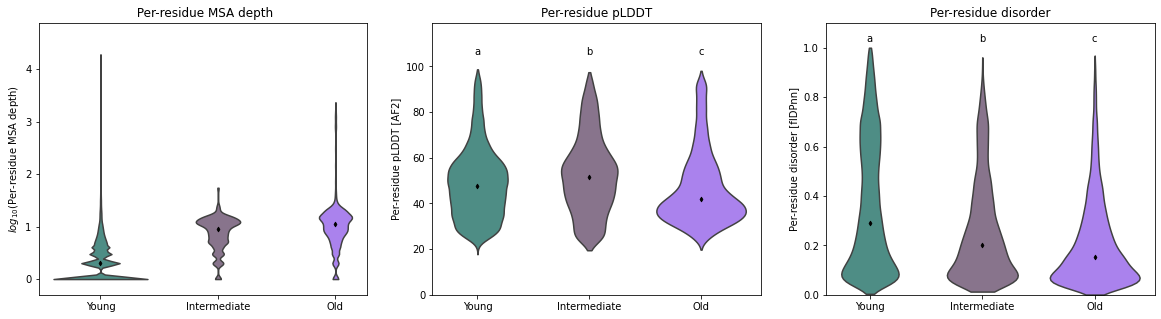

In [9]:
palette_age = ["#43978D", "#8A7090", "#A570FF"]

#Violinplots for MSA Depth and pLDDT based on age groups
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.violinplot(x="age_group", y="MSA_log", data=df, ax=ax[0], inner=None, cut=0, palette=palette_age)
ax[0].scatter([0, 1, 2], df.groupby("age_group")["MSA_log"].median(), color="black", s=10, marker="d")
ax[0].set_ylabel(r"$log_{10}$(Per-residue MSA depth)")
ax[0].set_xlabel("")
ax[0].set_xticklabels(["Young", "Intermediate", "Old"])
ax[0].set_ylim(-0.3, 4.88)

sns.violinplot(x="age_group", y="pLDDT", data=df, ax=ax[1], inner=None, cut=0, palette=palette_age)
ax[1].scatter([0, 1, 2], df.groupby("age_group")["pLDDT"].median(), color="black", s=10, marker="d")
ax[1].set_ylabel("Per-residue pLDDT [AF2]")
ax[1].set_xlabel("")
ax[1].set_xticklabels(["Young", "Intermediate", "Old"])
ax[1].set_ylim(0, 119)

sns.violinplot(x="age_group", y="Disorder_flDPnn", data=df, ax=ax[2], inner=None, cut=0, palette=palette_age)
ax[2].scatter([0, 1, 2], df.groupby("age_group")["Disorder_flDPnn"].median(), color="black", s=10, marker="d")
ax[2].set_ylabel("Per-residue disorder [flDPnn]")
ax[2].set_xlabel("")
ax[2].set_xticklabels(["Young", "Intermediate", "Old"])
ax[2].set_ylim(0, 1.1)


ax[0].set_title(" Per-residue MSA depth")
ax[1].set_title("Per-residue pLDDT")
ax[2].set_title("Per-residue disorder")


#calculate significance using kruskal-wallis test and dunn's post-hoc test
kw_msa = kruskal(df[df["age_group"] == 1]["MSA_log"], df[df["age_group"] == 2]["MSA_log"], df[df["age_group"] == 3]["MSA_log"])
data_msa = [df[df["age_group"] == 1]["MSA_log"], df[df["age_group"] == 2]["MSA_log"], df[df["age_group"] == 3]["MSA_log"]]
dunn_msa = posthoc_dunn(data_msa, p_adjust = 'holm')
print(f"Kruskal-Wallis test for MSA Depth: {kw_msa}")
print(f"Dunn's post-hoc test for MSA Depth:\n{dunn_msa}")

print("\n")

kw_plddt = kruskal(df[df["age_group"] == 1]["pLDDT"], df[df["age_group"] == 2]["pLDDT"], df[df["age_group"] == 3]["pLDDT"])
data_plddt = [df[df["age_group"] == 1]["pLDDT"], df[df["age_group"] == 2]["pLDDT"], df[df["age_group"] == 3]["pLDDT"]]
dunn_plddt = posthoc_dunn(data_plddt, p_adjust = 'holm')
print(f"Kruskal-Wallis test for pLDDT: {kw_plddt}")
print(f"Dunn's post-hoc test for pLDDT:\n{dunn_plddt}")

print("\n")
kw_disorder = kruskal(df[df["age_group"] == 1]["Disorder_flDPnn"], df[df["age_group"] == 2]["Disorder_flDPnn"], df[df["age_group"] == 3]["Disorder_flDPnn"])
data_disorder = [df[df["age_group"] == 1]["Disorder_flDPnn"], df[df["age_group"] == 2]["Disorder_flDPnn"], df[df["age_group"] == 3]["Disorder_flDPnn"]]
dunn_disorder = posthoc_dunn(data_disorder, p_adjust = 'holm')
print(f"Kruskal-Wallis test for Disorder: {kw_disorder}")
print(f"Dunn's post-hoc test for Per-residue disorder:\n{dunn_disorder}")

ax[1].text(0, 105, "a", ha="center")
ax[1].text(1, 105, "b", ha="center")
ax[1].text(2, 105, "c", ha="center")

ax[2].text(0, 1.025, "a", ha="center")
ax[2].text(1, 1.025, "b", ha="center")
ax[2].text(2, 1.025, "c", ha="center");

#plt.savefig("../manuscript_figures/per_residue_violinplots_age_group.png", dpi=600)


---
## Per Amino Acid Analysis

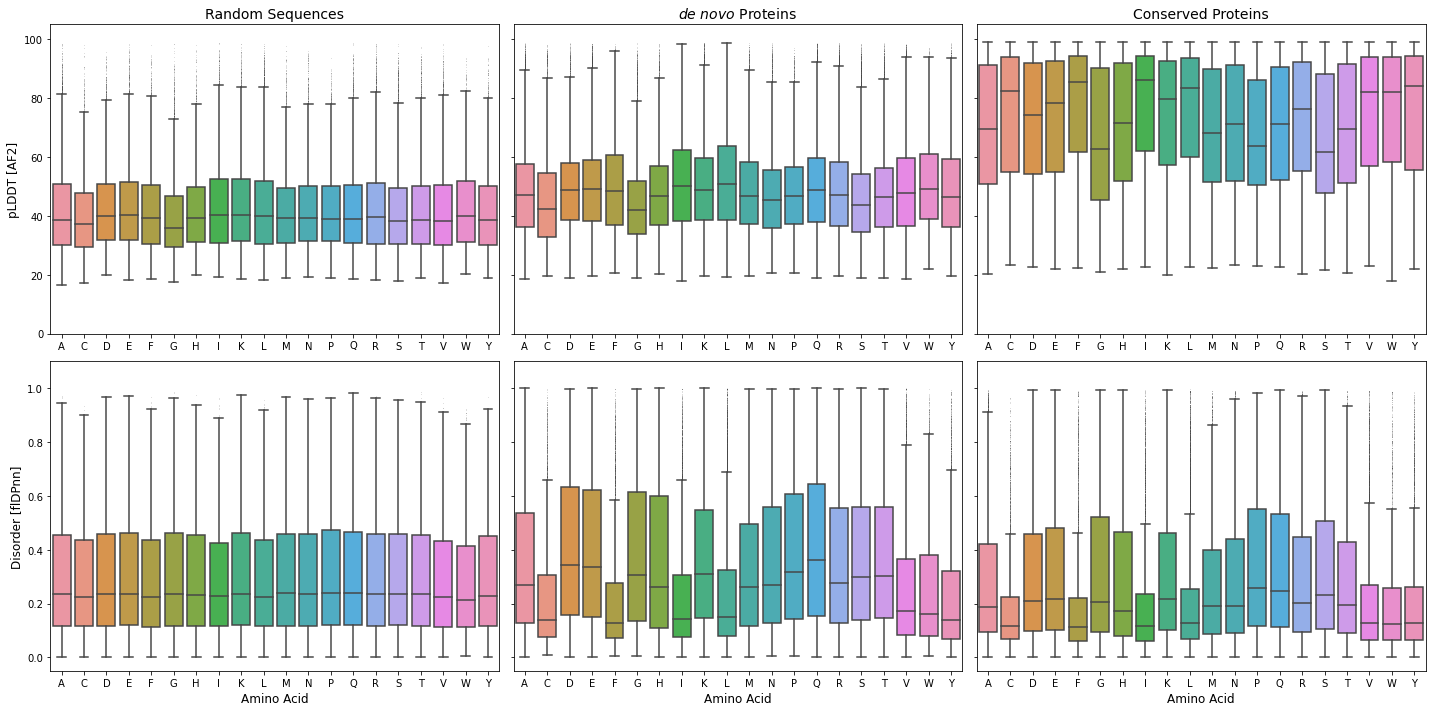

In [8]:
#create 2x3 subplot for boxplots of plddt and disorder per amino acid for df, rd and con

con_AA = con[con["AA"] != "X"]

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

#boxplots for pLDDT
sns.boxplot(data=rd.sort_values(by=["AA"]), x="AA", y="pLDDT", ax=ax[0,0], fliersize=0.05)
ax[0,0].set_title("Random Sequences", fontsize=14)
ax[0,0].set_ylim(0,105)
ax[0,0].set_ylabel("pLDDT [AF2]", fontsize=12)
ax[0,0].set_xlabel("")

sns.boxplot(data=df.sort_values(by=["AA"]), x="AA", y="pLDDT", ax=ax[0,1], fliersize=0.05)
ax[0,1].set_title(r"$\it{de}$ $\it{novo}$ Proteins", fontsize=14)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[0,1].set_ylim(0,105)
ax[0,1].set_yticklabels([])

sns.boxplot(data=con_AA.sort_values(by=["AA"]), x="AA", y="pLDDT", ax=ax[0,2], fliersize=0.05)
ax[0,2].set_title("Conserved Proteins", fontsize=14)
ax[0,2].set_xlabel("")
ax[0,2].set_ylabel("")
ax[0,2].set_ylim(0,105)
ax[0,2].set_yticklabels([])

#boxplots for disorder
sns.boxplot(data=rd.sort_values(by=["AA"]), x="AA", y="Disorder_flDPnn", ax=ax[1,0], fliersize=0.05)
ax[1,0].set_ylim(-0.05,1.1)
ax[1,0].set_ylabel("Disorder [flDPnn]", fontsize=12)
ax[1,0].set_xlabel("Amino Acid", fontsize=12)

sns.boxplot(data=df.sort_values(by=["AA"]), x="AA", y="Disorder_flDPnn", ax=ax[1,1], fliersize=0.05)
ax[1,1].set_xlabel("Amino Acid", fontsize=12)
ax[1,1].set_ylabel("")
ax[1,1].set_ylim(-0.05,1.1)
ax[1,1].set_yticklabels([])

sns.boxplot(data=con_AA.sort_values(by=["AA"]), x="AA", y="Disorder_flDPnn", ax=ax[1,2], fliersize=0.05)
ax[1,2].set_xlabel("Amino Acid", fontsize=12)
ax[1,2].set_ylabel("")
ax[1,2].set_ylim(-0.05,1.1)
ax[1,2].set_yticklabels([])

plt.tight_layout()



